# Exploratory Data Analysis of the S&P data

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import calendar
import datetime
from pandas.plotting import register_matplotlib_converters
import sys

sys.path.append("../") # go to parent dir
from util.read_data import DataReader

Le'ts read the data from CSV file. 

**Note:** The DataReader and few other utility classes are implemented in python files (not Jupyter notebook) and properly (unit) tested.

In [2]:
reader = DataReader()
# reading data which are not normalized 
df = reader.read_all_data()

# see the columns and data types
df.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume          float64
DayOfWeek        object
Month             int64
AdjClose        float64
OpenDiff        float64
CloseDiff       float64
AdjCloseDiff    float64
HighLowDiff     float64
dtype: object

Le't now look at few basic plots

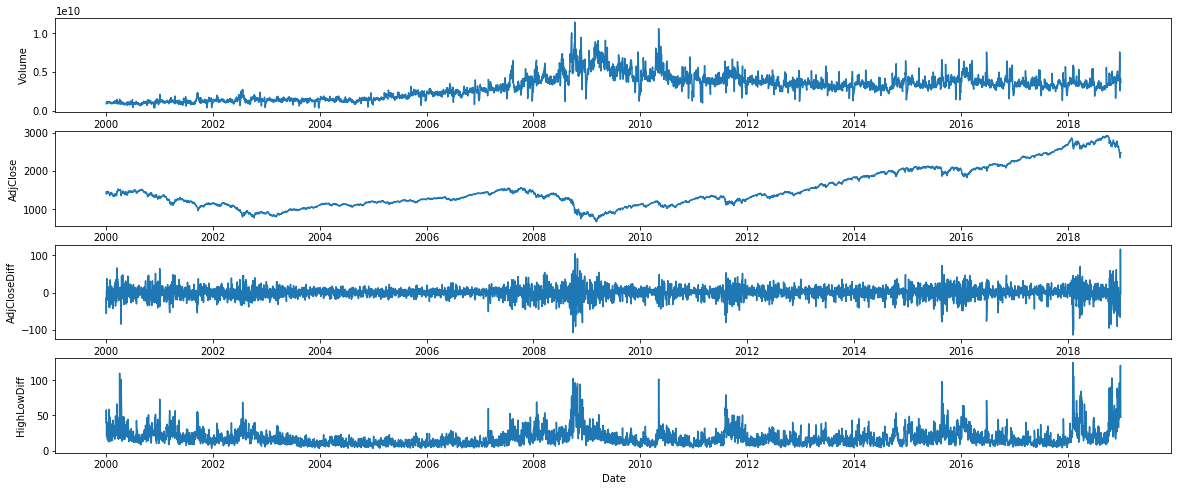

In [4]:
fig, ax = plt.subplots(4,1)
fig.set_size_inches(20, 8)
register_matplotlib_converters()

sns.lineplot(df.index, df.Volume, ax=ax[0])
sns.lineplot(df.index, df.AdjClose, ax=ax[1])
sns.lineplot(df.index, df.AdjCloseDiff, ax=ax[2])
sns.lineplot(df.index, df.HighLowDiff, ax=ax[3])


* The first plot is a plot of the Volume over time. It has its high and low peeks. There seems to be the positive trend (increasing of a volume) at least between 2004 - 2008. The market between 2008 - 2011 was more volatile, due to the financial crisis. The volume between 210 - now does not seem to have trend.
**Insights:** 
    * Positive trend between 2004 - 200
    * High volatility during finantial crisis
    * Both previous points might influence performance of the Machine Learning predictions on the test set, as the test set does not show either of those

* The second plot is a plot of a Adjusted Close price over time. There is a positive trend between 2003 - 2008, between 2009 - 2018. There is no obvious correlation between Volume and the Adjusted Close price.
**Insights:**
    * Positive trends
    * *Presumably:* no correlation between Volume and AdjCloseDiff

* The third graph is a plot fo a difference betwen the Adjusted Close price (AdjCloseDiff) of the two consecutive trading dates over time. There seems to be strong correlation between the Volume and the AdjCloseDiff. *Speculation:* When there is a new information comming to the market, the price will more likely change.
**Insights:**
    * Strong correlation betwen the Volume and AdjCloseDiff
    * *Hypothesis (1):* The information from the AdjCloseDiff of the previous date could have influence on the Volume of the next date,
    
* The forth graph is a plot of the difference between the High and Low price (HighLowDiff) during trading day over time. Similari as the previous graph, there seems to be correlation between HighLowDiff and Volume. *Speculation:* When there is a new information comming to the market, the higher volatility of the price over trading day will cause higher spread of the High and Low price. 
**Insights:**
    * Strong correlation betwen the HighLowDiff and AdjCloseDiff
    * *Hypothesis (2):* The information from the HighLowDiff of the previous date could have influence on the Volume of the next date
 
Le'ts now have a look at the graphs in higher detail:   

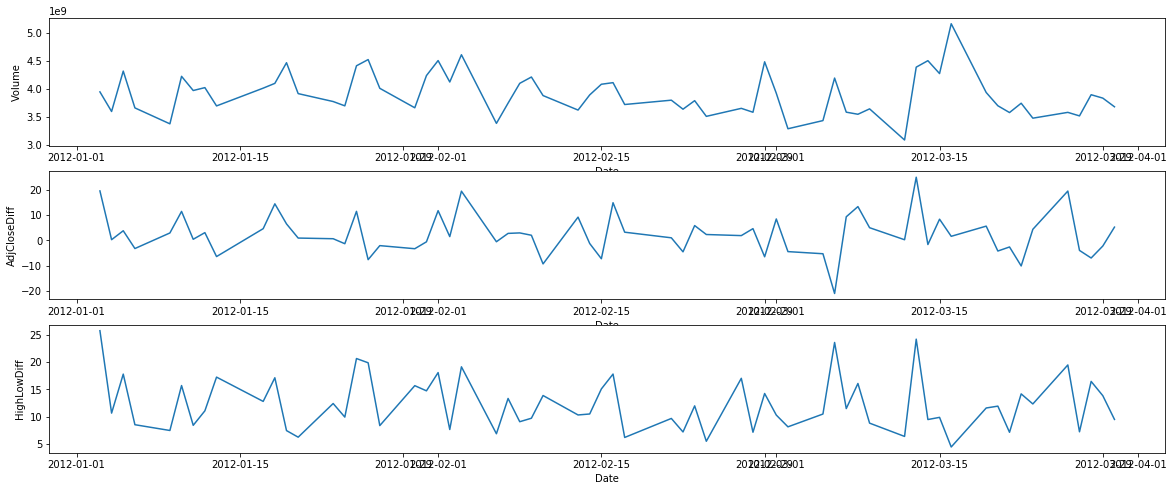

In [12]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(20, 8)
register_matplotlib_converters()

df_detail = df.loc[datetime.datetime(2012,1,1):datetime.datetime(2012,4,1)]

sns.lineplot(df_detail.index, df_detail.Volume, ax=ax[0])
sns.lineplot(df_detail.index, df_detail.AdjCloseDiff, ax=ax[1])
sns.lineplot(df_detail.index, df_detail.HighLowDiff, ax=ax[2])

The higher detail plots show that the high and low values are often correla ted - high Volume of trade coused e.g. bytsome new information means often that the AdjCloseDiff and HighLowDiff will be also high.

Next plot we will look at is distribution of the Volume.

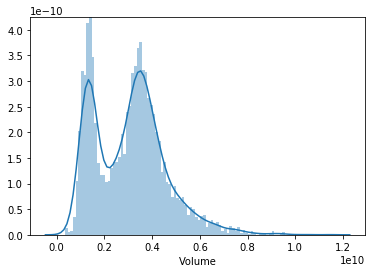

In [16]:
sns.distplot(df.Volume, bins=100)

There are two peek in the distribution, peek with a low volume of trade and peek with a high volume of trade. 
    
*Hypothesis (3):* It seem obvious from the Volume graph, as the average Volume before year 2009 is a lot smaller than the average Volume after 2009. To confirm the hypothesis, let's look at the Volume distribution after 2009.

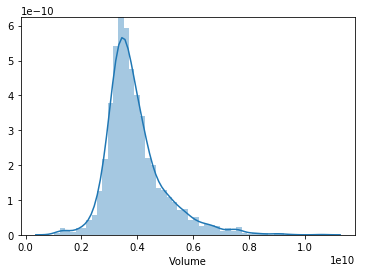

In [20]:
sns.distplot(df.loc[datetime.datetime(2009,1,1):].Volume)

The *hypothesis(3)* is confirmed, now the graph have nice gaussian bell shape. 

Let's now look at the distributions of Volume for individual days of week.

*Hypothesis (4):* The traiding volume could be higher on average on Monday, as there is more chance that more information could appear over the weekend.

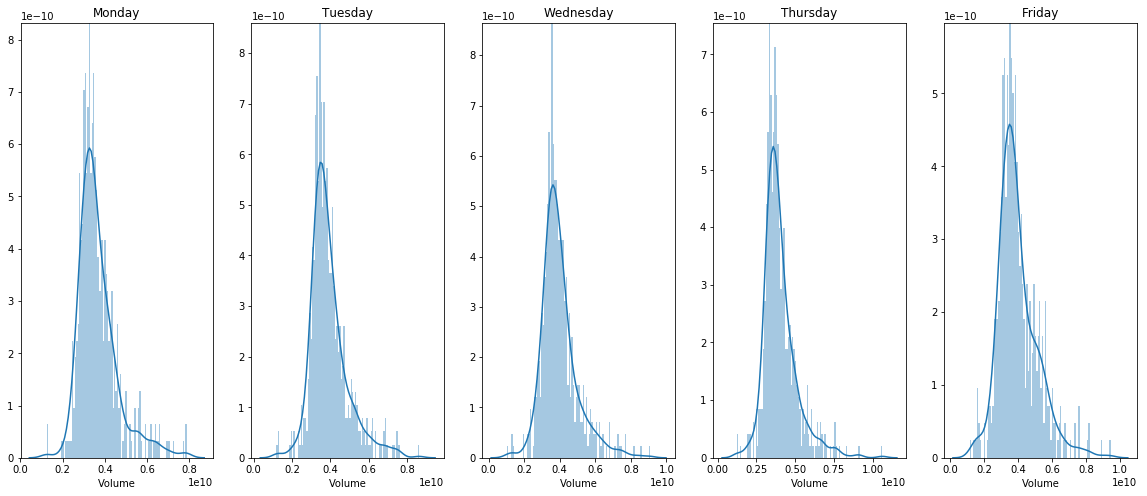

In [25]:
fig, ax = plt.subplots(1,5)
fig.set_size_inches(20, 8)

# we are interested only in the volumes after 2009, as they are more relevant
df_after_2009 = df.loc[datetime.datetime(2009,1,1):]
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
for index, day in enumerate(days):
    plot = sns.distplot(df_after_2009[df_after_2009['DayOfWeek'] == day].Volume, bins=100, ax=ax[index])
    plot.set_title(calendar.day_name[index])


There is some difference of distributions for various days of week, however, the differences are not so obvious, the *hypothesis (4)* is not confirmed, neither denied. We might do some statistical test, e.g. Student's t-test, to confirm/deny the hypothesis, null hypothesis being that the mean of distributions is the same.
Still, we can add day of week feature to the set of features for our model.

Let's now try to find dependence of Volume on the month.

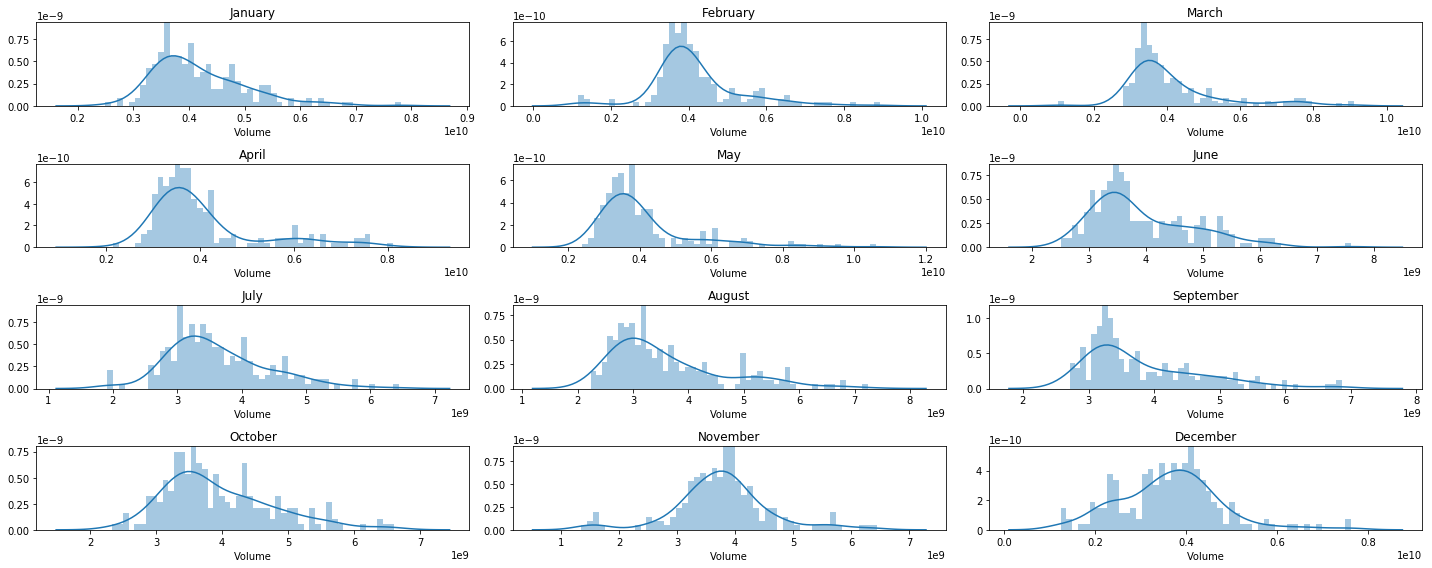

In [27]:
fig, ax = plt.subplots(4, 3)
fig.set_size_inches(20, 8)

months = range(1, 13)

for month in months:
    plot = sns.distplot(df_after_2009[df_after_2009['Month'] == month].Volume, bins=50, 
                        ax=ax[int((month-1) / 3), (month-1) % 3])
    plot.set_title(calendar.month_name[month])
fig.tight_layout()


The distribution graphs show that there is significat difference between months in trading Volume. E.g., the June and July are particularly quiet months. *Speculation:* It is likely caused by the fact that traders and policy makers from Northern hemisphere are on vacation during June and July.  

The distribution graphs shows that our models could benefit from adding month as a feature.

Let't look at the correlations of the individual numeric features. We are especially interested whether market  data from previous day can have influence on the Volume of present day.

In [44]:
df_for_corr = df.copy()
# we will shift market data by one day
columns_to_be_shifted = ['Open','High','Low','Close','AdjClose','OpenDiff','CloseDiff','AdjCloseDiff','HighLowDiff']
df_for_corr[columns_to_be_shifted] = df_for_corr[columns_to_be_shifted].shift(1)
# we will create column with shifted Volume 
df_for_corr['Volume_prev'] = df_for_corr['Volume'].shift(1)

# show correlations, we will look at 'DayOfWeek', 'Month' later
df_for_corr.drop(['DayOfWeek', 'Month'], axis=1).corr()

,Open,High,Low,Close,Volume,AdjClose,OpenDiff,CloseDiff,AdjCloseDiff,HighLowDiff,Volume_prev
Open,1.000000,0.999836,0.999755,0.999563,0.159232,0.999563,0.026789,-0.000844,-0.000844,0.096951,0.157614
High,0.999836,1.000000,0.999706,0.999785,0.161460,0.999785,0.024442,0.012006,0.012006,0.105671,0.160592
Low,0.999755,0.999706,1.000000,0.999811,0.155201,0.999811,0.030015,0.015892,0.015892,0.081545,0.153174
Close,0.999563,0.999785,0.999811,1.000000,0.157900,1.000000,0.026333,0.028087,0.028087,0.092507,0.156908
Volume,0.159232,0.161460,0.155201,0.157900,1.000000,0.157900,-0.037135,-0.047298,-0.047298,0.271968,0.917736
AdjClose,0.999563,0.999785,0.999811,1.000000,0.157900,1.000000,0.026333,0.028087,0.028087,0.092507,0.156908
OpenDiff,0.026789,0.024442,0.030015,0.026333,-0.037135,0.026333,1.000000,0.025157,0.025157,-0.226397,-0.048150
CloseDiff,-0.000844,0.012006,0.015892,0.028087,-0.047298,0.028087,0.025157,1.000000,1.000000,-0.158361,-0.025939
AdjCloseDiff,-0.000844,0.012006,0.015892,0.028087,-0.047298,0.028087,0.025157,1.000000,1.000000,-0.158361,-0.025939
HighLowDiff,0.096951,0.105671,0.081545,0.092507,0.271968,0.092507,-0.226397,-0.158361,-0.158361,1.000000,0.319463


The correlation of individual features Open, High, Low, Close is so strong, that id does not make sense to use all features in the model. Most of the information covered by one feature is also contained in all other features. It makes sense however to use daily difference HighLowDiff, or AdjCloseDiff. There seems to be some non-negligible correlation between HighLowDiff and Volume and strong correlation between previous Volume and current Volume.
**Insights:**
   * Experiment with baseline model: volume(t) = volume(t-1)
   * Use HighLowDiff feature in a model